# Approximation de la finesse maximale avec un _réseau neuronal convolutif_
#### _Étude de profil d’aile d’avion par Machine Learning_ - _Université de Sherbrooke_
#### 
__Auteur__ : _Ilyas Baktache_  
__Année__ : 2022  
 

__Objectif__ :  On cherche à developper un algorithme CNN capable de produire la finesse maximale d’un profil pour un nombre de Mach et de Reynolds donné.

## Librairies

In [4]:
import sys
sys.path.append( os.path.dirname( os.path.dirname( os.path.abspath('airfoil_Optimisation_ML') ) ) )
from data.pre_processing import *

from CNN.approx_finesse_CNN import *
# Data manipulation
import pickle
import random
import pandas as pd
import seaborn as snc

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Reshape, GlobalAveragePooling1D, LeakyReLU, Input,concatenate
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.metrics import classification_report

## Import des données

On prepare dans un premier temps les données et les labels

In [5]:
x,ally,nom_profil,marchepas = format.coordinate()
print("Pour des raisons divers, {} profils ne peuvent pas être utilisé dans notre etude.".format(len(marchepas)))
n = np.shape(ally)[1]
p = np.shape(ally)[0]
print("On obtient alors une matrice X de taille ({},{})".format(p,n))

FileNotFoundError: [Errno 2] No such file or directory: 'data/Airfoil_Coordinate'

In [11]:
# On cherche les données de polaire pour un nombre de Mach nul et 
# des nombres de Reynolds allant de 50000 à 1000000
M = 0
Re_list=[50000,100000,200000,500000,1000000]

# On note dans cette liste les finesses maximales
finesse_max = np.zeros((len(nom_profil),len(Re_list)))
no_data_all = [] 
for j in range(len(Re_list)):
    Re = Re_list[j]
    # Certaines données de polaire ne sont pas disponible pour tous
    # les profils
    no_data = [] 
    for i in range(len(nom_profil)):
        name = nom_profil[i]
        alpha,cL,cD,cDp,cM = utils.polarFile2list(name,M,Re)
        # Ici on choisit alpha = 0
        try :
            cL = np.array(cL)
            cD = np.array(cD)
            finesse = cL/cD
            finesse_max[i,j] = np.max(finesse)
        except:
            no_data.append(name)
    no_data_all.append(no_data)

On arrondis les finesses maximale à une décimale près pour simplifier à améliorer la précision de notre algorithme par la suite.

In [12]:
finesse_max = finesse_max.round(1).T
len(finesse_max.T)

1628

On crée maintenant des listes de coordonnées pour tous les profils pour chaque couple Nombre de Mach/Nombre de Reynolds en fonction des données disponibles.

In [13]:
# M = 0, Re = 50000
ally_0_50000 = ally.copy()
nom_profil_0_50000 = nom_profil.copy()
finesse_max_0_50000 = list(finesse_max[0])
z = [False for _ in range(len(nom_profil_0_50000))]
for nom in no_data_all[0]:
    index = nom_profil.index(nom)
    z[index] = True
    finesse_max_0_50000.pop(index)
    nom_profil_0_50000.pop(index)
ally_0_50000 = ally_0_50000.compress(np.logical_not(z), axis = 1)

# M = 0, Re = 100000
ally_0_100000 = ally.copy()
nom_profil_0_100000 = nom_profil.copy()
finesse_max_0_100000 = list(finesse_max[1])
z = [False for _ in range(len(nom_profil_0_100000))]
for nom in no_data_all[1]:
    index = nom_profil.index(nom)
    z[index] = True
    finesse_max_0_100000.pop(index)
    nom_profil_0_100000.pop(index)
ally_0_100000 = ally_0_100000.compress(np.logical_not(z), axis = 1)


# M = 0, Re = 200000
ally_0_200000 = ally.copy()
nom_profil_0_200000 = nom_profil.copy()
finesse_max_0_200000 = list(finesse_max[2])
z = [False for _ in range(len(nom_profil_0_200000))]
for nom in no_data_all[2]:
    index = nom_profil.index(nom)
    z[index] = True
    finesse_max_0_200000.pop(index)
    nom_profil_0_200000.pop(index)
ally_0_200000 = ally_0_200000.compress(np.logical_not(z), axis = 1)


# M = 0, Re = 500000
ally_0_500000 = ally.copy()
nom_profil_0_500000 = nom_profil.copy()
finesse_max_0_500000 = list(finesse_max[3])
z = [False for _ in range(len(nom_profil_0_500000))]
for nom in no_data_all[3]:
    index = nom_profil.index(nom)
    z[index] = True
    finesse_max_0_500000.pop(index)
    nom_profil_0_500000.pop(index)
ally_0_500000 = ally_0_500000.compress(np.logical_not(z), axis = 1)


# M = 0, Re = 1000000
ally_0_1000000 = ally.copy()
nom_profil_0_1000000 = nom_profil.copy()
finesse_max_0_1000000 = list(finesse_max[4])
z = [False for _ in range(len(nom_profil_0_1000000))]
for nom in no_data_all[4]:
    index = nom_profil.index(nom)
    z[index] = True
    finesse_max_0_1000000.pop(index)
    nom_profil_0_1000000.pop(index)
ally_0_1000000 = ally_0_1000000.compress(np.logical_not(z), axis = 1)

finesse_max = [finesse_max_0_50000,finesse_max_0_100000,finesse_max_0_200000,finesse_max_0_500000,finesse_max_0_1000000]
nom_profil_tt_Re = [nom_profil_0_50000,nom_profil_0_100000,nom_profil_0_200000,nom_profil_0_500000,nom_profil_0_1000000]

In [6]:
print(np.shape(ally_0_100000)[1],len(nom_profil_0_50000))

1624 1625


## Étiquette

L'étiquette qu'on cherche à produire avec notre algorithme sera la finesse maximale du profil pour un nombre de Reynolds donné

Pour le réseau convulutif, il est plus simple et plus optimal de définir des classes à la place de float. Ainsi, nous allons proposer diverses modèles d'ettiquette chacune avec un certain nombre de classe. Dans un premier temps, regardons nos echantillons de finesse maximale pour chaque Re:

Pour un nombre de Reynolds de 50000, la finesse maximale est de 59.2 et la finesse minimale de -0.1.


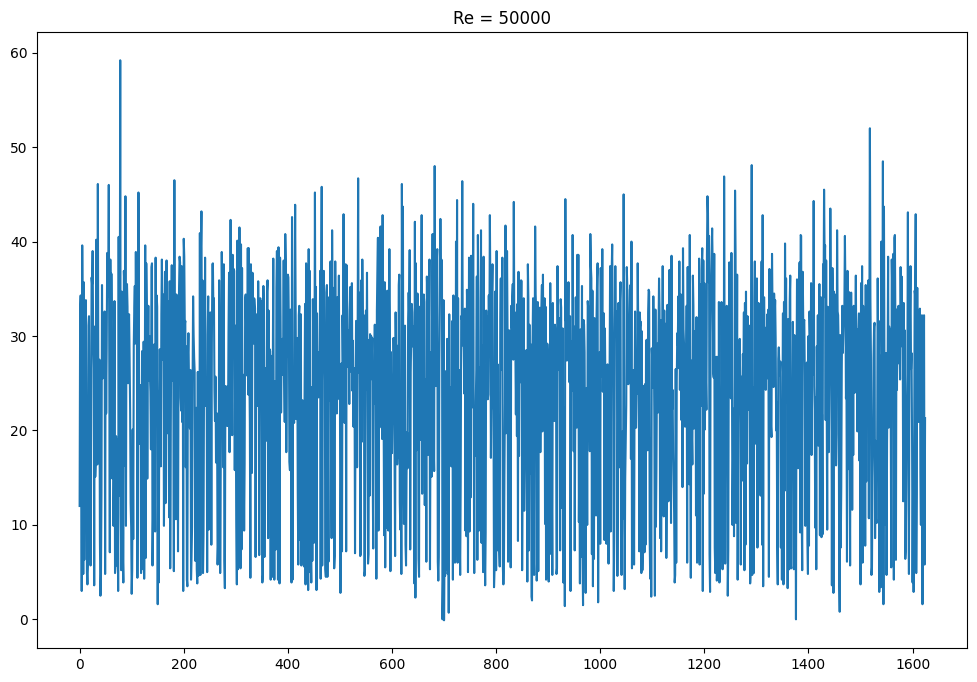

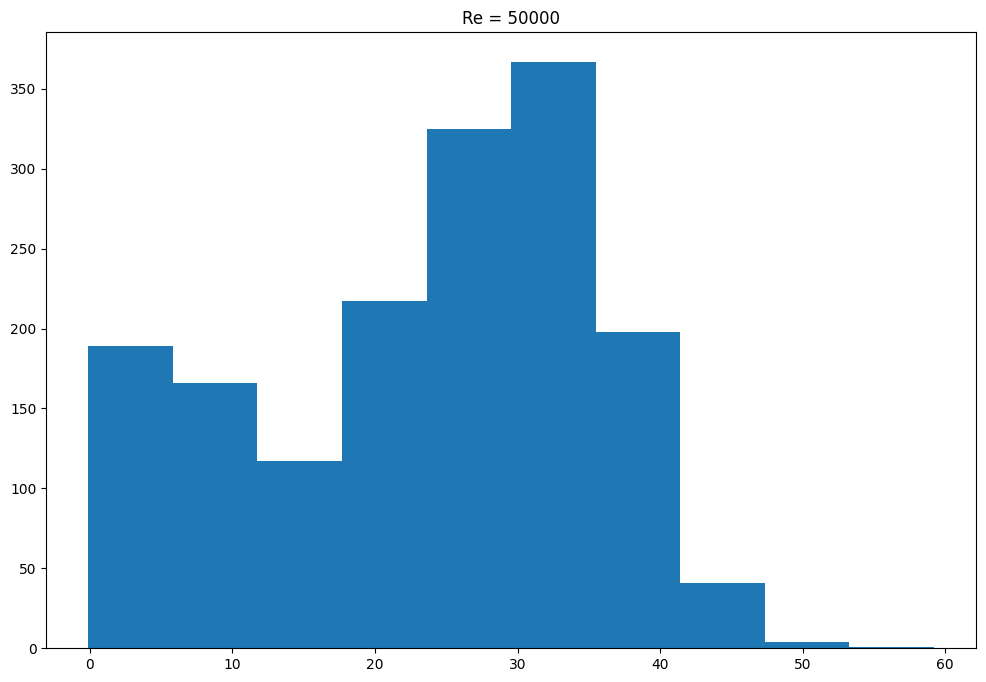

Pour un nombre de Reynolds de 100000, la finesse maximale est de 105.6 et la finesse minimale de -0.5.


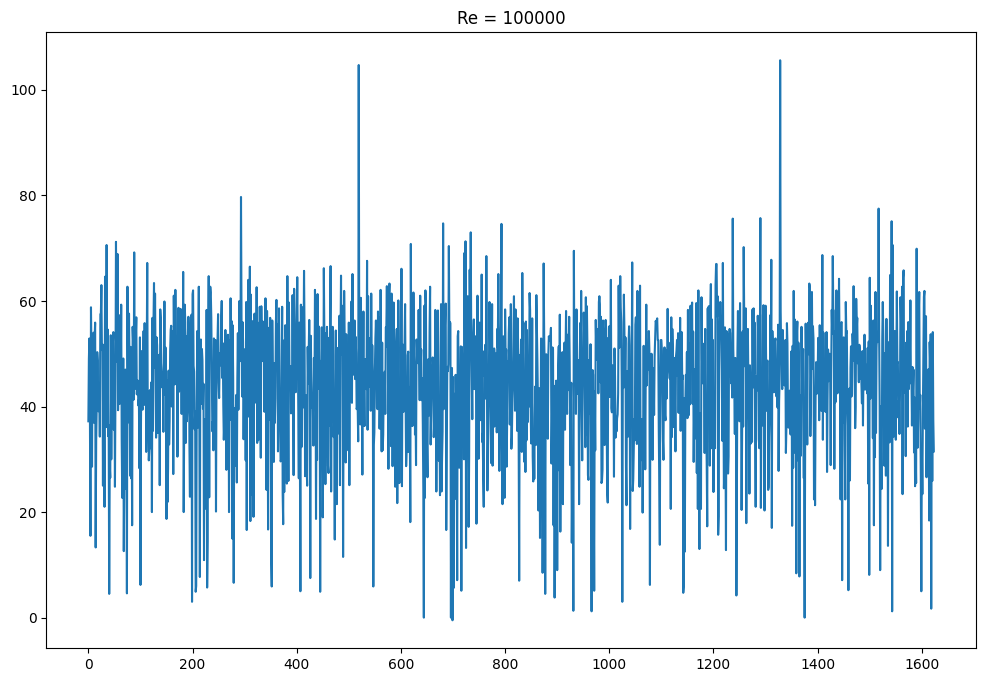

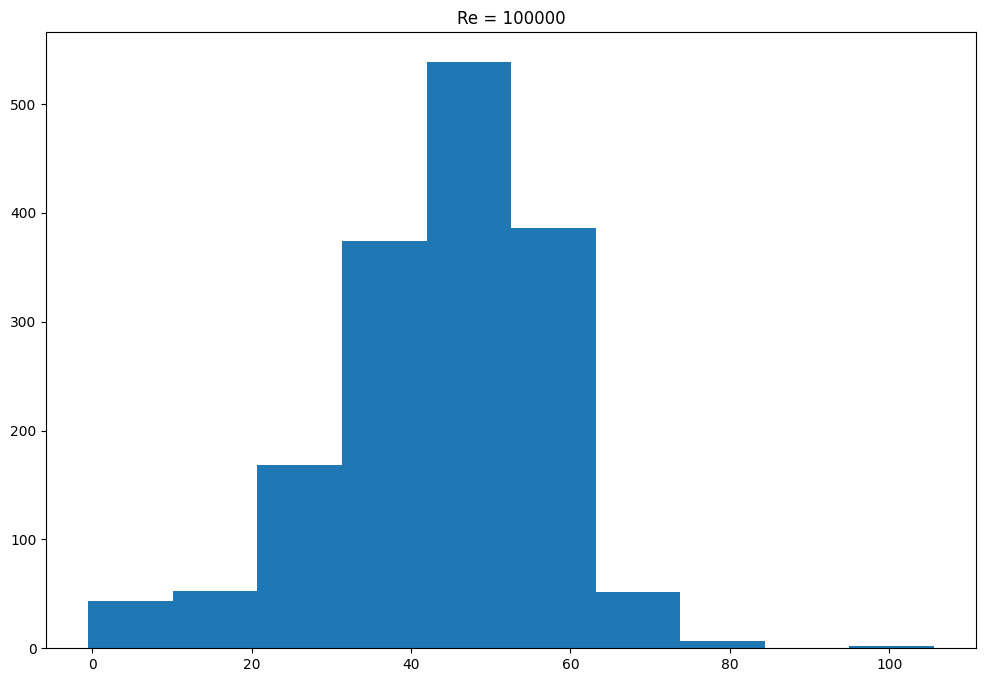

Pour un nombre de Reynolds de 200000, la finesse maximale est de 162.0 et la finesse minimale de 0.0.


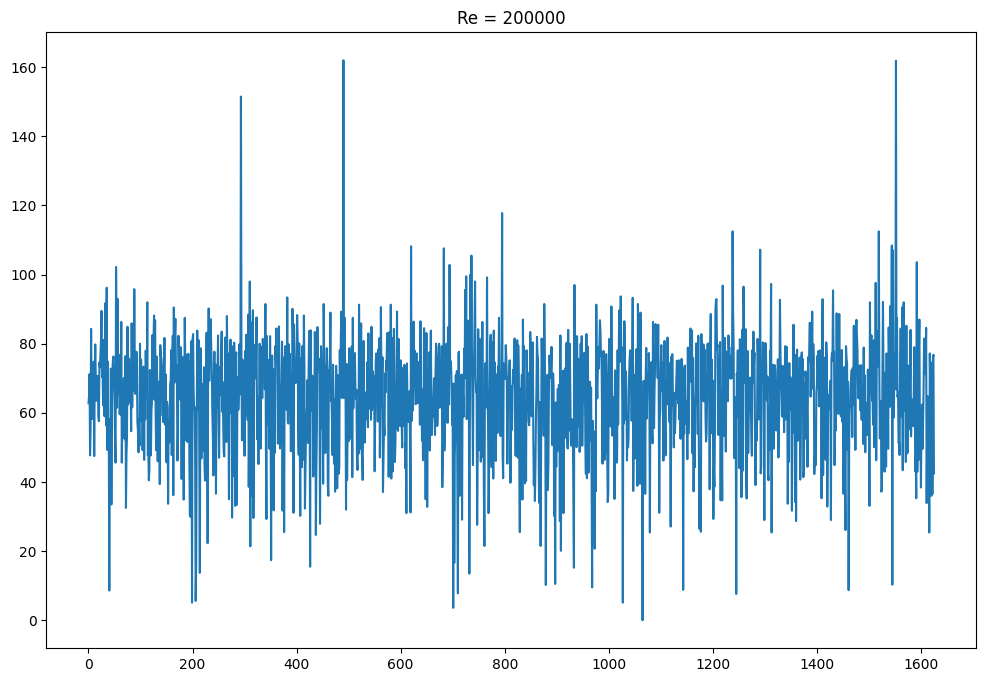

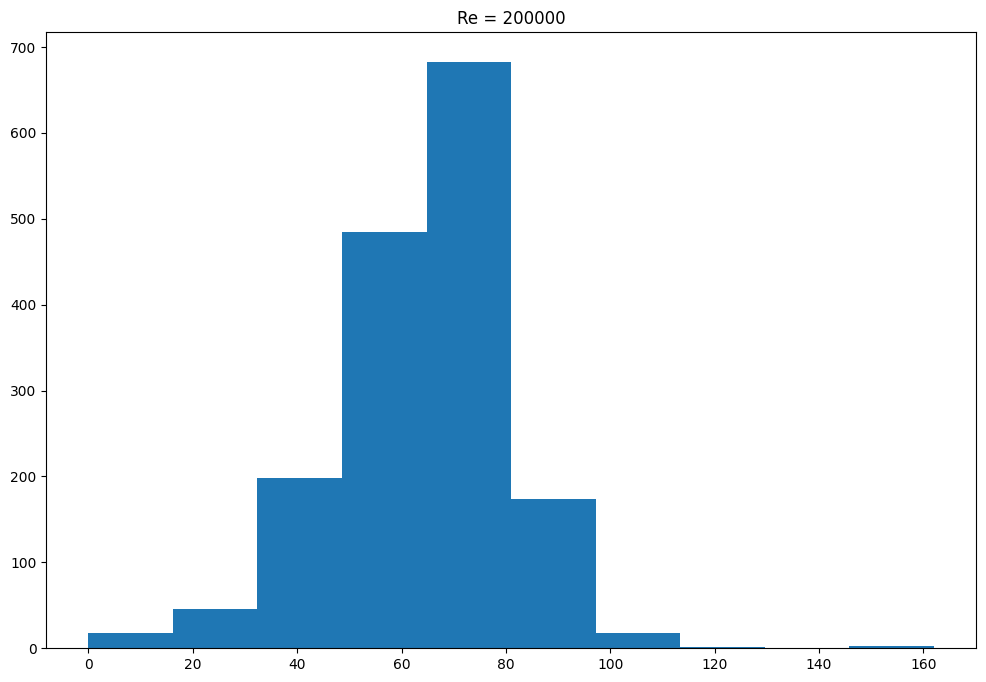

Pour un nombre de Reynolds de 500000, la finesse maximale est de 176.8 et la finesse minimale de 0.0.


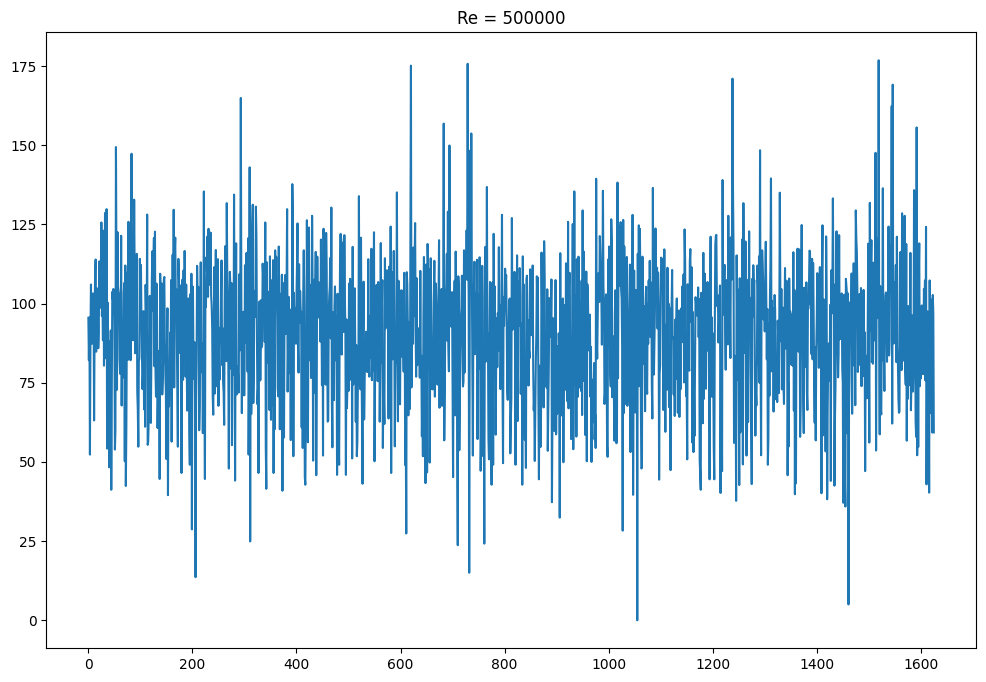

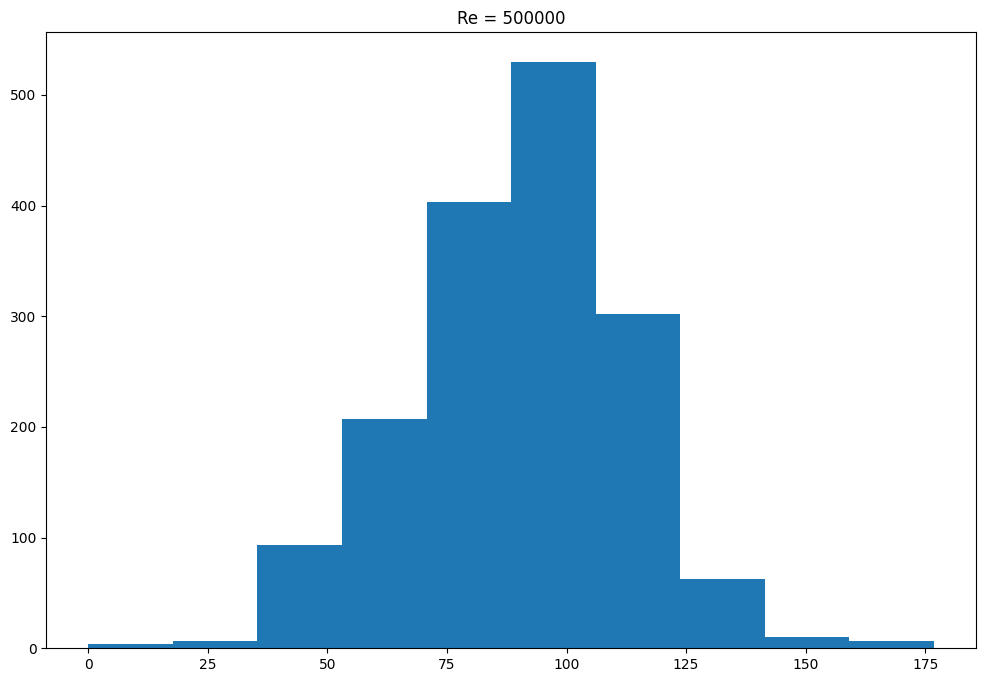

Pour un nombre de Reynolds de 1000000, la finesse maximale est de 235.7 et la finesse minimale de 0.0.


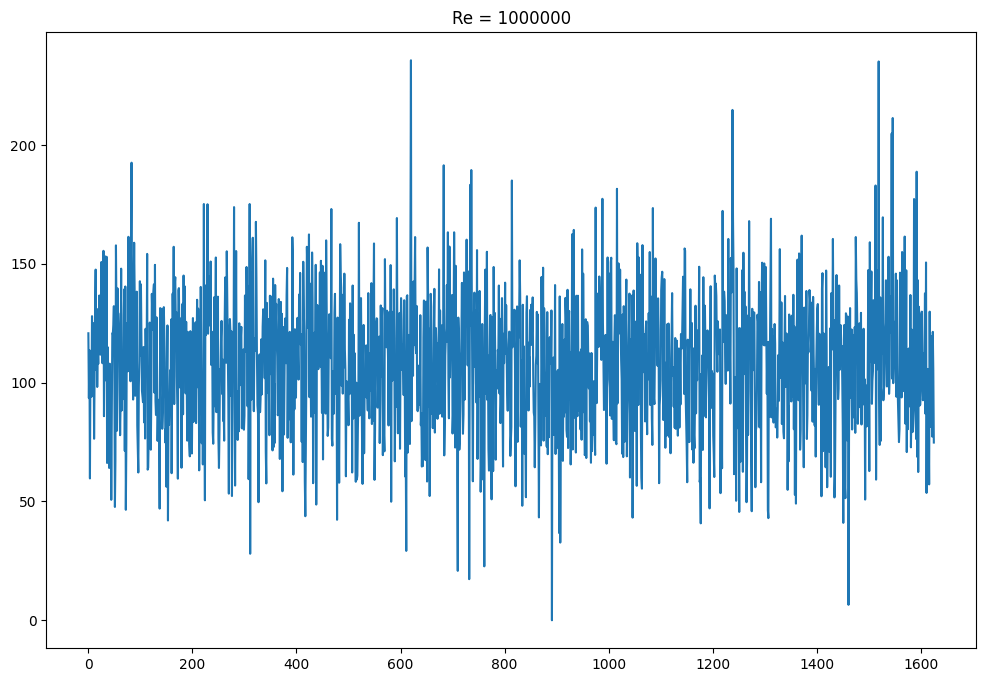

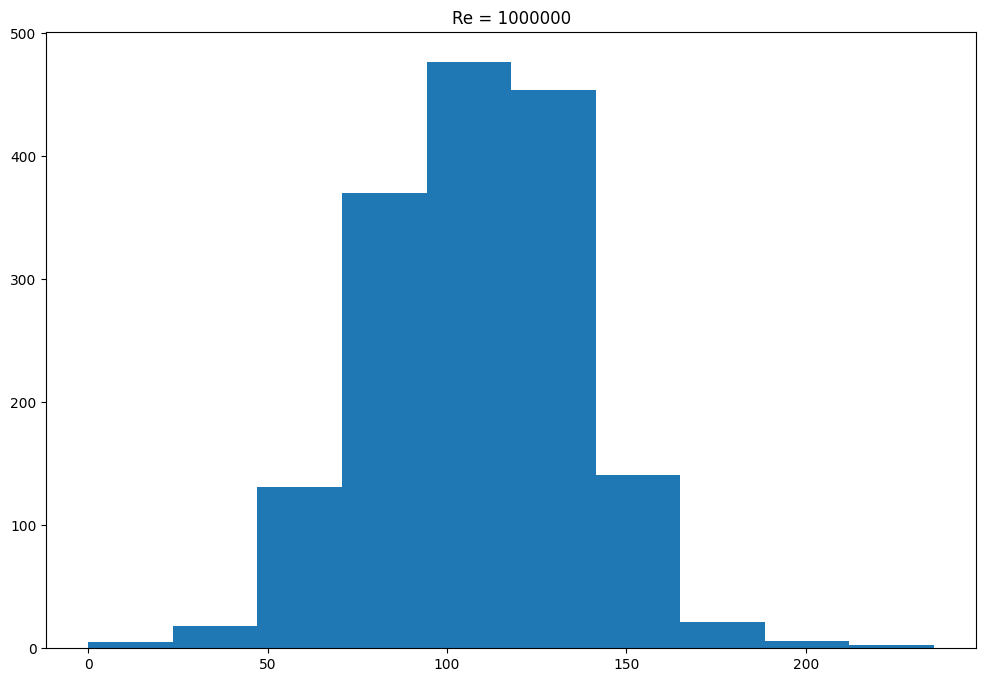

In [14]:
for i in range(5):
    list_finesse_Re = finesse_max[i]
    Re = Re_list[i]
    maxfin = np.max(list_finesse_Re)
    minfin = np.min(list_finesse_Re)
    print("Pour un nombre de Reynolds de {}, la finesse maximale est de {} et la finesse minimale de {}.".format(Re,maxfin,minfin))
    plt.figure(figsize = (12,8))
    plt.plot(list_finesse_Re)
    plt.title('Re = {}'.format(Re))
    plt.figure(figsize = (12,8))
    plt.hist(list_finesse_Re)
    plt.title('Re = {}'.format(Re))
    plt.show()


On peut voir que pour chaque nombre de Reynolds à disposition. la distribution de finesses max des profils est différentes. On doit alors définir des classes adaptés pour chaque nombre de Reynolds.  Pour cela on devellope trois fonctions:
* Une fonction qui prends en entrée la liste des finesses max pour tous les profils et qui sort une discritisation basé sur la distribution de finesse et le nombre de classes désirée. 
* Une fonction qui permet de passer de la finesse maximale à la classe
* Une fonction qui permet de passer de la classe à la finesse maximale

Afin de réaliser une telle fonction, on s'interesse à l'agorithme de Fisher-Jenks qui est une sorte de K-means clustering pour des problèmes en 1D. On utilise pour l'implémenter la librairie Pandas et la librairie jenkspy de Matthieu Viry.

In [15]:
import jenkspy as jk

def discretisation_label(nom_profil_Re,finesse_max_Re,nb_class):
    Re_fin = {'nom' : nom_profil_Re, 
                    'finesse_max' : finesse_max_Re}

    df_fin = pd.DataFrame(Re_fin)

    intervalle_finesse_max = jk.jenks_breaks(df_fin['finesse_max'], n_classes=nb_class)
    df_fin['classe'] = pd.cut(df_fin['finesse_max'],
                        bins=intervalle_finesse_max,
                        labels=[i for i in range(1,nb_class+1)],
                        include_lowest=True)
    return df_fin, intervalle_finesse_max

df_fin, intervalle_finesse_max = discretisation_label(nom_profil_0_50000,finesse_max[0],100)

La fonction ci-dessus associe donc chaque profil a une classe suivante sa finesse max et fournit également une liste des intervalles qui permettent de lier les classes au finesses. On crée maintenant une fonction qui permet de passer de la classe d'un profils à sa finesse max. On décide de prendre la moyenne de l'intervalle et de l'associé à la finesse.

In [16]:
def classe2finesse_max(classe,intervalle_finesse_max):
    finesse_max_loc = (intervalle_finesse_max[classe-1] + intervalle_finesse_max[classe])/2
    return np.round(finesse_max_loc,2)

classe2finesse_max(1,intervalle_finesse_max)

-0.05

On ajoute alors les finesses approximées avec la fonction ci-dessus et notre système de classe dans le dataframe pandas.

In [17]:
def finesse_classe(df_fin,intervalle_finesse_max):
    # Cette fonction permet de rajouter dans le dataframe pandas
    # les données de finesse_max associée au classes
    finesse_max_fct = []
    for i in range(len(df_fin['finesse_max'])):
        classe = df_fin['classe'][i]
        finesse_max_fct.append(classe2finesse_max(classe,intervalle_finesse_max))
    
    df_fin['finesse_max_class'] = finesse_max_fct
    return df_fin

df_fin = finesse_classe(df_fin,intervalle_finesse_max)
df_fin


,nom,finesse_max,classe,finesse_max_class
0,mh104-il,12.0,24,11.60
1,df102-il,32.7,70,32.75
2,naca2411-il,34.3,74,34.30
3,n63010a-il,27.3,56,27.05
4,goe777-il,3.0,5,2.95
...,...,...,...,...
1620,s825-nr,29.3,62,29.30
1621,sc20518-il,26.0,53,25.80
1622,clarkk-il,32.2,68,32.10
1623,fxs21158-il,5.8,12,5.70


On cherche alors à étudier la pertinence et la précision de ce modèle en comparant les finesses données par notre fonction $fin_{max_{fc}}$ et la finesse max réelle du profil $fin_{max_{Re}}$ (erreur relative) __en fonction du nombre de classe__:
$$
\text{err} = \frac{\left|fin_{max_{Re}} - fin_{max_{fc}}\right|}{\left|fin_{max_{Re}}\right|} 
$$

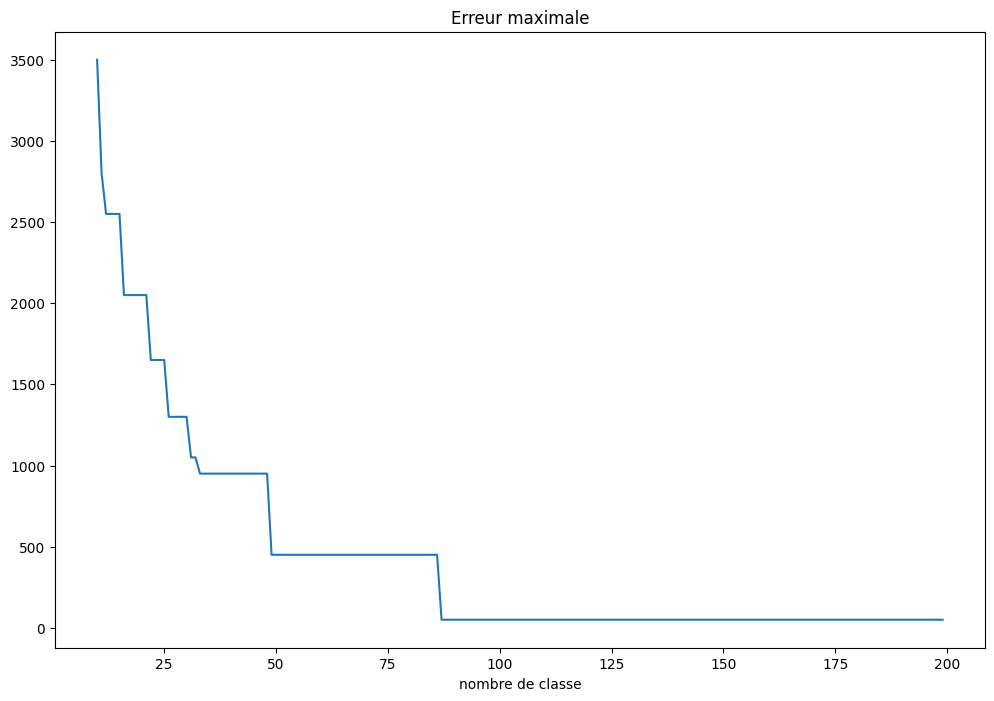

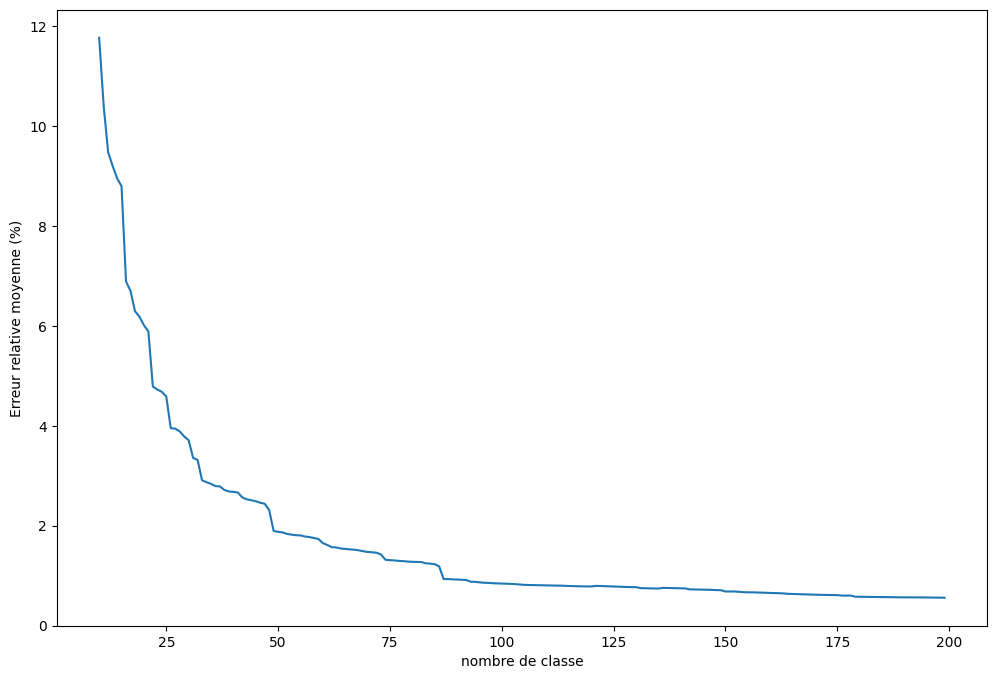

In [18]:
def comparaison_fin_fct_Re(nom_profil_Re,finesse_max_Re,nb_class):
    
    df_fin, intervalle_finesse_max = discretisation_label(nom_profil_Re,finesse_max_Re,nb_class)
    df_fin = finesse_classe(df_fin,intervalle_finesse_max)

    list_err = []
    for i in range(len(df_fin['finesse_max'])):
        finesse_max_reelle = df_fin['finesse_max'][i]
        finesse_max_fct = df_fin['finesse_max_class'][i]
        
        if finesse_max_reelle != 0:
            err = np.abs((finesse_max_reelle - finesse_max_fct)) / np.abs((finesse_max_reelle))
        else :
            pass
        list_err.append(err)
    
    return list_err

err_max = []
err_moy = []
for nb_class in range(10,200):
    list_err = comparaison_fin_fct_Re(nom_profil_0_50000,finesse_max[0],nb_class)
    err_max.append(np.max(list_err)*100)
    err_moy.append(np.mean(list_err)*100)

plt.figure(figsize = (12,8))
plt.plot(range(10,200),err_max)
plt.xlabel('nombre de classe')
plt.title('Erreur maximale')
plt.show()

plt.figure(figsize = (12,8))
plt.plot(range(10,200),err_moy)
plt.xlabel('nombre de classe')
plt.ylabel('Erreur relative moyenne (%)')
plt.show()

On peut voir que l'erreur maximale converge vers 50% à partir d'un nombre de classe égale à __87__. Cela s'explique par le fait que pour des petites finesse l'erreur relative est facilement grande. Par exemple si la finesse réelle est à 0.05 et que la finesse approximée par le mdoèle de classe est 0.1 alors l'erreur relative sera:
$$
\left(\frac{|0.2 - 0.1|}{0.2}\right)\cdot 100=  50\%
$$

Alors que l'ecart absolu est de 0.1 ce qui est relativement faible et acceptable.

On s'interesse donc plus à l'erreur moyenne qui est plus indicatrice de la précision du modèle. Elle devient inférieur à 1% à partir d'un nombre de classe égale à __87__. Ainsi, __ces observations nous poussent à choisir un nombre de classe de 87__. 

On réalise maintenant la même étude pour le reste des nombres de Reynolds. 

In [19]:
def choix_nb_classe(nom_profil_Re,finesse_max_Re,Re):
    index_class = []

    for nb_class in range(10,100):
        try:
            list_err = comparaison_fin_fct_Re(nom_profil_Re,finesse_max_Re,nb_class)
            err_max = (np.max(list_err)*100)
            err_moy = (np.mean(list_err)*100)

            if err_max <= 50 and err_moy <= 1:
                index_class.append(nb_class)
        except:
            pass

    print('Pour Re = {}, il faut prendre {} classes pour respecter les critères.'.format(Re,index_class[0]))
    return index_class[0]

# On note alors le nombres de classes nécessaire pour 
# chaque Re dans une liste
nb_class_list = []
for i in range(5):
    nb_class_list.append(choix_nb_classe(nom_profil_tt_Re[i],finesse_max[i],Re_list[i]))

Pour Re = 50000, il faut prendre 87 classes pour respecter les critères.
Pour Re = 100000, il faut prendre 59 classes pour respecter les critères.
Pour Re = 200000, il faut prendre 44 classes pour respecter les critères.
Pour Re = 500000, il faut prendre 40 classes pour respecter les critères.
Pour Re = 1000000, il faut prendre 42 classes pour respecter les critères.


Le nombre de classes pertinent reste cependant relativement haut du fait du petit nombre de données de profils qu'on possède. On teste donc avec différent nombres de classes en commencant par 5:

On crée alors les listes des labels qu'on appelle _finesse_max_fct_ pour tous les Re

In [24]:
finesse_max_classe = []

def list_label(nom_profil_Re,finesse_max_Re,nb_class):
    df_fin, intervalle_finesse_max = discretisation_label(nom_profil_Re,finesse_max_Re,nb_class)
    df_fin = finesse_classe(df_fin,intervalle_finesse_max)
    classe_list = list(df_fin['classe'])

    return classe_list

for i in range(5):
    finesse_max_classe.append(list_label(nom_profil_tt_Re[i],finesse_max[i],nb_class_list[i]))



### Partionnement des données

On doit maintenant distinguer 2 groupes de données:
* Données d'entrainement: 80% de la totalité des données (Données de validation: 10% des données d'entrainement.).
* Données de tests: 20% de la totalité des données.


In [25]:
def split_data(dataset,finesse_max):

    dataset = np.matrix.tolist(dataset.T)
    # Number of data 
    num = len(dataset)

    # Number of each dataset : Train and Test.
    n_train  = int(num*0.7)
    n_test  = int(num*0.3)

    while n_train+n_test !=num:
        n_train+=1
    
    # All the index of the big dataset
    allindex = [i for i in range(num)]

    # Random list of index of the train dataset
    list_train = random.sample(allindex, n_train)
    # List of allindex without the train index
    index_notrain = list(set(allindex)-set(list_train))

    # List of random train index
    list_test = random.sample(index_notrain, n_test)

    x_train = []
    x_test = []

    y_test = []
    y_train = []
    for i in allindex:
        if i in list_train:
            x_train.append(dataset[i])
            y_train.append(finesse_max[i])
        elif i in list_test:
            x_test.append(dataset[i])
            y_test.append(finesse_max[i])
    return x_train,y_train,x_test,y_test

### Dictionnaire de données

Afin de simplifier notre travail par la suite, on crée des dictionnaires qui regroupe toutes les données préparées dans les sections precédentes 

In [26]:
x_train,y_train,x_test,y_test = split_data(ally_0_50000,finesse_max_classe[0])
dict_0_50000 = {'x_train' : x_train,
                'y_train' : y_train,
                'x_test' : x_test,
                'y_test':y_test,
                'nom_profil' : nom_profil_0_50000,
                'nb_classe' : nb_class_list[0]}

x_train,y_train,x_test,y_test = split_data(ally_0_100000,finesse_max_classe[1])
dict_0_100000 = {'x_train' : x_train,
                'y_train' : y_train,
                'x_test' : x_test,
                'y_test':y_test,
                'nom_profil' : nom_profil_0_100000,
                'nb_classe' : nb_class_list[2]}

x_train,y_train,x_test,y_test = split_data(ally_0_200000,finesse_max_classe[2])
dict_0_200000 = {'x_train' : x_train,
                'y_train' : y_train,
                'x_test' : x_test,
                'y_test':y_test,
                'nom_profil' : nom_profil_0_200000,
                'nb_classe' : nb_class_list[2]}

x_train,y_train,x_test,y_test = split_data(ally_0_500000,finesse_max_classe[3])
dict_0_500000 = {'x_train' : x_train,
                'y_train' : y_train,
                'x_test' : x_test,
                'y_test':y_test,
                'nom_profil' : nom_profil_0_500000,
                'nb_classe' : nb_class_list[3]}

x_train,y_train,x_test,y_test = split_data(ally_0_1000000,finesse_max_classe[4])
dict_0_1000000 = {'x_train' : x_train,
                'y_train' : y_train,
                'x_test' : x_test,
                'y_test':y_test,
                'nom_profil' : nom_profil_0_1000000,
                'nb_classe' : nb_class_list[4]}

##  Modèle de réseau neuronal profond

Dans cette section, nous allons construire le modèle de réseau neuronal profond. On s'interesse dans un premier temps à M=0 et Re=50000:


In [27]:
# Importe les données d'entrainement
x_train = np.array(dict_0_50000['x_train']).astype('float32')
y_train = np.array(dict_0_50000['y_train']).astype('float32')

# Importe les données de test
x_test = np.array(dict_0_50000['x_test']).astype('float32')
y_test = np.array(dict_0_50000['y_test']).astype('float32')

# Nombre de coordonnées et de profils
nb_coord,nb_profil = np.shape(x_train)[1],np.shape(x_train)[0]

# Nombre de classes à définir
nb_class = dict_0_50000['nb_classe']

# one-hot-encoding of our labels
y_train = y_train - 1
y_train_hot = to_categorical(y_train, nb_class)
y_test = y_test - 1
y_test_hot = to_categorical(y_test, nb_class)

print(" On initialise l'apprentissage avec {} données de profils pour l'entrainement et {} données de profils pour l'entrainement. Dans le but de trouver {} classes de finesse max.".format(x_train.shape[0],x_test.shape[0],nb_class))

 On initialise l'apprentissage avec 1138 données de profils pour l'entrainement et 487 données de profils pour l'entrainement. Dans le but de trouver 87 classes de finesse max.


### Modèle 1

On définis dans un premier temps un modèle simple consitué de deux couches entierements connectés uniquement:
* __Une couche entièrement connectée avec activation Leaky ReLu__ : La couche caché va permettre d'obtenir un réseau avec des poids adaptés
* __Une couche entièrement connectée avec activation Softmax__ : La couche finale va réduire le vecteur de hauteur 124 à un vecteur de nb_class puisque nous avons nb_classclasses que nous voulons prédire. Cette réduction est effectuée par une autre multiplication matricielle. Softmax est utilisé comme fonction d'activation. Elle force la somme des six sorties du réseau neuronal à être égale à un. La valeur de sortie représente donc la probabilité de chacune des nb_class classes.

In [28]:
model_1 = Sequential()
# hidden layer
model_1.add(Dense(125, input_shape=(nb_coord,), activation=LeakyReLU()))
# output layer
model_1.add(Dense(87, activation='softmax'))

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 125)               14875     
_________________________________________________________________
dense_1 (Dense)              (None, 87)                10962     
Total params: 25,837
Trainable params: 25,837
Non-trainable params: 0
_________________________________________________________________
None



Dans le but d'avoir de trouver le meilleurs modèle en terme de précision de l'approximation de la classe de finesse, on en teste plusieurs

### Modèle 2

On detaille le premier modèle qu'on va tester:
* __Entrée et Reshape__ : Les données ont été pré-traité et on se retrouve avec une matrice (nb_profils, nb_coord) et un array label (nb_profils,). On reshape les données pour leurs rajouter une dimension pour qu'il soit plus facilement traité par keras.
* __La première couche 1D CNN__ : La première couche définit un filtre (ou également appelé détecteur de caractéristiques) de hauteur 10 (également appelé taille du noyau). La définition d'un seul filtre permettrait au réseau neuronal d'apprendre une seule caractéristique dans la première couche. Cela peut ne pas être suffisant, c'est pourquoi nous allons définir 100 filtres. Cela nous permet de former 100 caractéristiques différentes sur la première couche du réseau. 

* __La seconde couche 1D CNN__: Le résultat du premier CNN sera introduit dans la deuxième couche CNN. Nous allons à nouveau définir 100 filtres différents à entraîner sur ce niveau.

* __Une couche de mise en commun maximale__ : Une couche de mise en commun est souvent utilisée après une couche CNN afin de réduire la complexité de la sortie et d'éviter un ajustement excessif des données. Dans notre exemple, nous avons choisi une taille de trois. Cela signifie que la taille de la matrice de sortie de cette couche est seulement un tiers de la matrice d'entrée. Il est donc fréquent d'insérer périodiquement une couche de pooling entre deux couches convolutives successives d'une architecture de réseau de neurones convolutifs pour réduire le sur-apprentissage.

* __Une troisième et quatrième couche 1D CNN__ : Une autre séquence de couches CNN 1D suit afin d'apprendre des caractéristiques de plus haut niveau.

* __Une couche de mise en commun moyenne__ : Une couche de mise en commun supplémentaire pour éviter l'overfitting. Cette fois, on ne prend pas la valeur maximale mais la valeur moyenne de deux poids du réseau neuronal. Par détecteur de caractéristiques, il ne reste qu'un seul poids dans le réseau neuronal sur cette couche.

* __Une couche d'exclusion__ : La couche d'abandon attribuera aléatoirement des poids nuls aux neurones du réseau. Comme nous avons choisi un taux de 0,5, 50 % des neurones recevront un poids nul. Grâce à cette opération, le réseau devient moins sensible pour réagir aux petites variations des données. Par conséquent, cela devrait encore augmenter notre précision sur les données non vues.

* __Une couche entièrement connectée avec activation Softmax__ : La couche finale va réduire le vecteur de hauteur 125 à un vecteur de nb_class puisque nous avons nb_classclasses que nous voulons prédire. Cette réduction est effectuée par une autre multiplication matricielle. Softmax est utilisé comme fonction d'activation. Elle force la somme des six sorties du réseau neuronal à être égale à un. La valeur de sortie représente donc la probabilité de chacune des nb_class classes.

In [29]:
model_2 = Sequential()
model_2.add(Reshape((nb_coord, 1), input_shape=(nb_coord,)))
model_2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_2.add(MaxPooling1D(pool_size=3))
model_2.add(Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_2.add(Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_2.add(GlobalAveragePooling1D())
model_2.add(Dropout(0.5))
model_2.add(Dense(124, activation='relu'))
model_2.add(Dense(nb_class, activation='softmax'))

print(model_2.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 118, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 100)           19300     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 100)           30100     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)              

### Modèle 3 

On améliore le modèle précedent en augmentant le nombre de couche convultive et pooling.

In [19]:
model_3 = Sequential()
model_3.add(Reshape((nb_coord, 1), input_shape=(nb_coord,)))
model_3.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(MaxPooling1D(pool_size=3))
model_3.add(Dropout(0.1))
model_3.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(MaxPooling1D(pool_size=3))
model_3.add(Dropout(0.25))
model_3.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(nb_coord,1)))
model_3.add(GlobalAveragePooling1D())
model_3.add(Dropout(0.5))
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(nb_class, activation='softmax'))

print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 118, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 116, 128)          512       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 114, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 36, 256)           98560     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 34, 256)          

### Modèle 4

Une autre approche populaire avec les CNN est d'avoir un modèle à plusieurs têtes, où chaque tête du modèle lit les pas de temps d'entrée en utilisant un noyau de taille différente. Dans notre cas, on test un modèle à trois têtes peut avoir trois tailles de noyau différentes (3, 5, 11), ce qui permet au modèle de lire et d'interpréter les données de la séquence à trois résolutions différentes. Les interprétations des trois têtes sont ensuite concaténées dans le modèle et interprétées par une couche entièrement connectée avant qu'une prédiction ne soit faite.



In [20]:
model_4 = Sequential()

model_4.add(Reshape((nb_coord, 1), input_shape=(nb_coord,)))
# Head 1
inputs1 = Input(shape = (nb_coord,1))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=3)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape = (nb_coord,1))
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=3)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape = (nb_coord,1))
conv3 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=3)(drop3)
flat3 = Flatten()(pool3)

# merge
merged = concatenate([flat1, flat2, flat3])

# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(nb_class, activation='softmax')(dense1)
model_4 = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)


plot_model(model_4, show_shapes=True, to_file='multichannel.png')
print(model_4.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 118, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 118, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 118, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 116, 64)      256         input_1[0][0]                    
______________________________________________________________________________________________

## Entrainement

In [21]:

model = model_1
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 1000

history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/1000


2022-10-24 16:37:54.624521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


19/19 [==============================] - 1s 44ms/step - loss: 4.4538 - accuracy: 0.0108 - val_loss: 4.4428 - val_accuracy: 0.0088
Epoch 2/1000
19/19 [==============================] - 0s 12ms/step - loss: 4.3831 - accuracy: 0.0204 - val_loss: 4.4149 - val_accuracy: 0.0175
Epoch 3/1000
19/19 [==============================] - 0s 12ms/step - loss: 4.2992 - accuracy: 0.0319 - val_loss: 4.3844 - val_accuracy: 0.0175
Epoch 4/1000
19/19 [==============================] - 0s 12ms/step - loss: 4.2509 - accuracy: 0.0438 - val_loss: 4.3477 - val_accuracy: 0.0351
Epoch 5/1000
19/19 [==============================] - 0s 12ms/step - loss: 4.2125 - accuracy: 0.0379 - val_loss: 4.3161 - val_accuracy: 0.0439
Epoch 6/1000
19/19 [==============================] - 0s 12ms/step - loss: 4.1639 - accuracy: 0.0405 - val_loss: 4.2849 - val_accuracy: 0.0395
Epoch 7/1000
19/19 [==============================] - 0s 11ms/step - loss: 4.1060 - accuracy: 0.0454 - val_loss: 4.2364 - val_accuracy: 0.0439
Epoch 8/1000

Les performances de ce DNN simple sont correctes. Nous avons une précision de validation d'environ 74%. Ce résultat pourrait certainement être amélioré, peut-être en ajustant davantage les hyperparamètres et surtout en modifiant la conception du réseau neuronal. Avant de passer à la validation du test, nous allons imprimer la courbe d'apprentissage pour l'ensemble des données de formation et de validation.

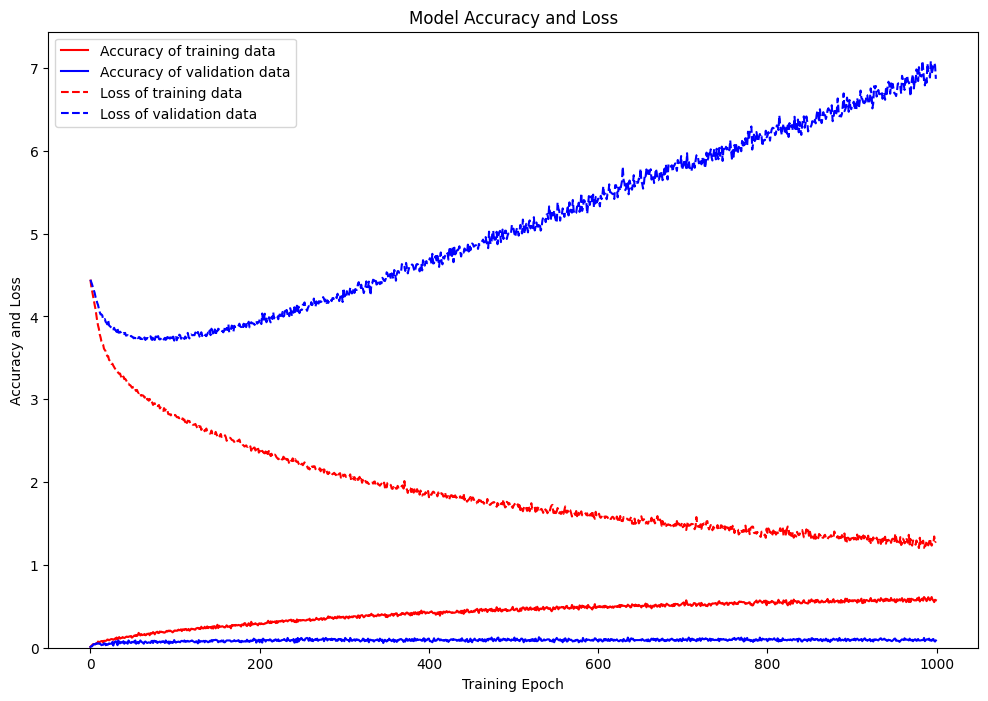

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       1.00      1.00      1.00         1
         2.0       0.83      1.00      0.91         5
         3.0       0.67      1.00      0.80         6
         4.0       0.76      0.93      0.84        14
         5.0       1.00      0.62      0.77         8
         6.0       0.85      0.79      0.81        14
         7.0       0.87      0.62      0.72        21
         8.0       1.00      0.32      0.49        28
         9.0       0.51      0.78      0.62        27
        10.0       0.33      0.09      0.14        11
        11.0       0.75      0.21      0.33        14
        12.0       0.38      0.69      0.49        13
        13.0       0.54      0.78      0.64         9
        14.0       0.44      0.86      0.59        14
        15.0       0.33      0.67      0.44        12
        16.0       0.83      0.42      0.56        12
        17.0       0.80    

/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/ENV/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/ENV/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/ENV/lib/python3.8/site-packages/sklearn/metrics/_c

In [22]:

plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict([x_train,x_train,x_train])
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

## Résultats

Dans cette section, on affiche les résultats pour chaque modèle issus des nombreuses heures d'entraînement.


### Modèle 1



#### Nombre de neurone

La précision maximal est obtenu pour le paramètre 4096


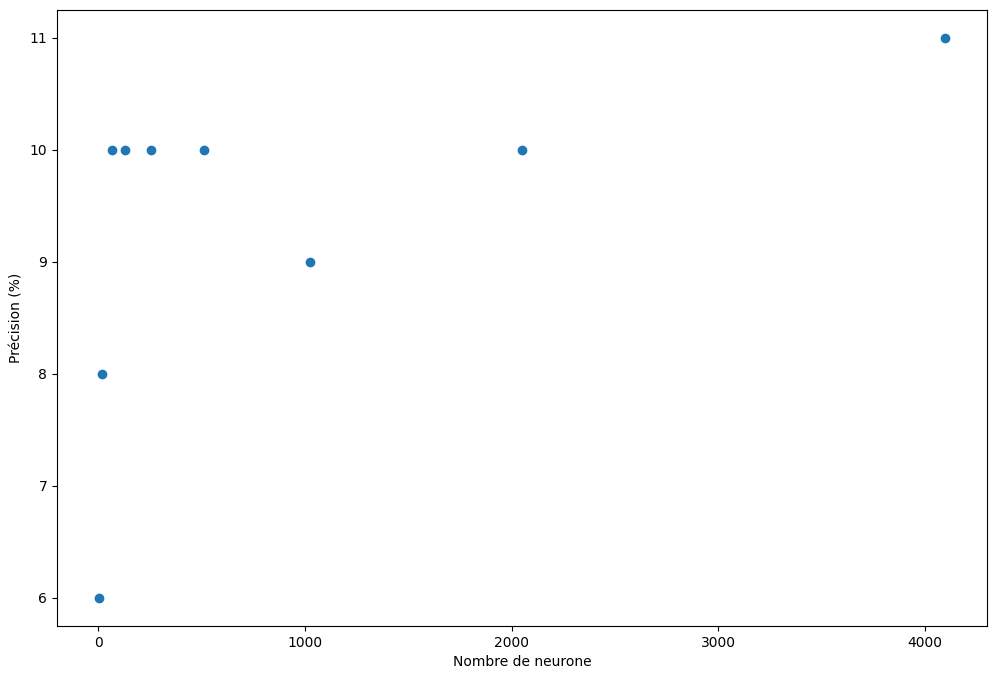

In [57]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_neurone(1,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_1 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre {}".format(param_1))

plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel('Nombre de neurone')
plt.ylabel('Précision (%)')
plt.show()

#### Nombre d'époque

La précision maximal est obtenu pour le paramètre 2000


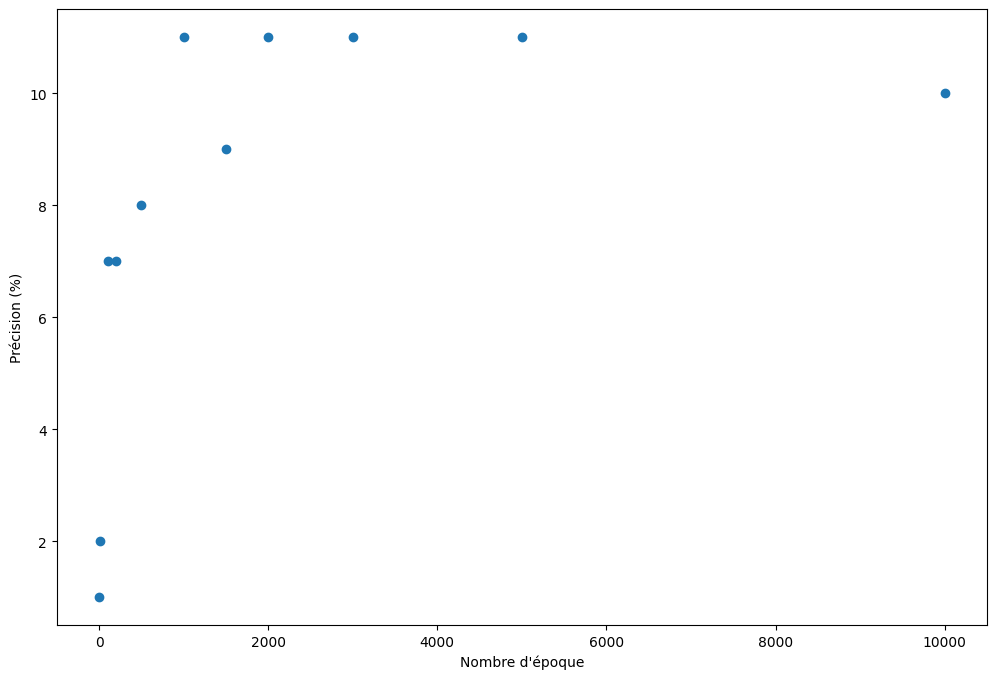

In [58]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_epoque(1,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_2 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre {}".format(param_2))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre d'époque")
plt.ylabel('Précision (%)')
plt.show()


#### Nombre de paquet

La précision maximal est obtenu pour le paramètre 10


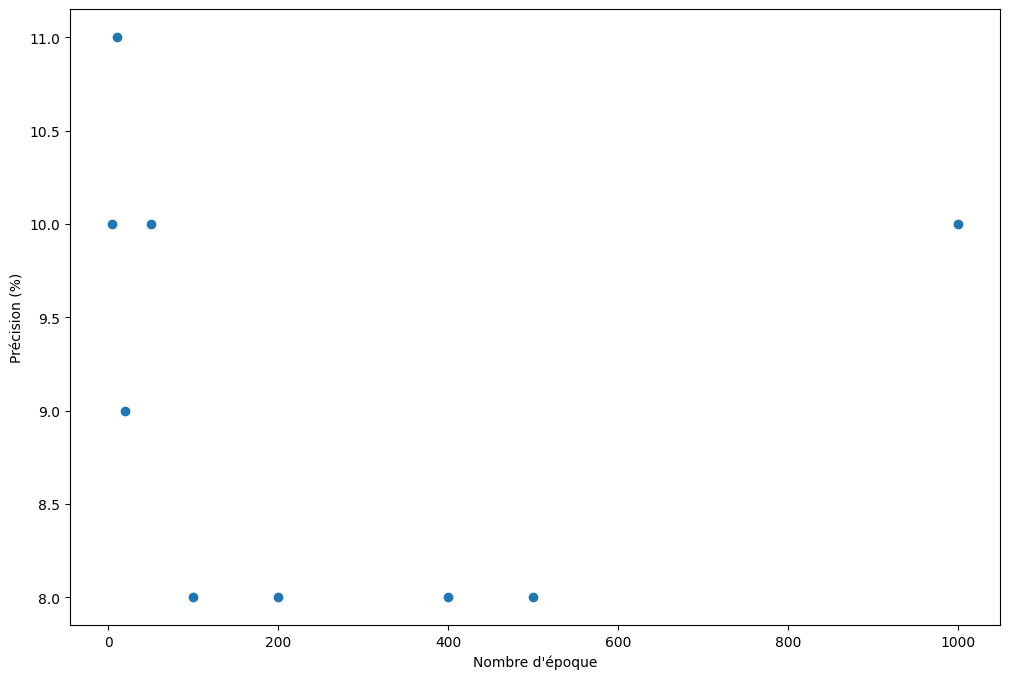

In [59]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_paquet(1,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_3 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre {}".format(param_3))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de paquet")
plt.ylabel('Précision (%)')
plt.show()

#### Meilleur modèle



In [87]:
x_train,y_train,y_train_hot,x_test,y_test,y_test_hot,nb_class = pre_process_CNN.data_CNN(M,Re)
# Nombre de coordonnées et de profils
nb_coord = np.shape(x_train)[1]

# On entre les meilleurs paramètres déterminés par tests
nb_neurone = param_1
number_of_epochs = param_2
batch_size = param_3


modele_1 = models.mod_1(nb_coord,nb_class,nb_neurones = nb_neurone,fct_activation=LeakyReLU)
modele_1.compile(loss='categorical_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
history = modele_1.fit(x_train,
                    y_train_hot,
                    batch_size=batch_size,
                    epochs=number_of_epochs,
                    validation_split=0.2,
                    verbose=1)

history_test = modele_1.evaluate(x_test,y_test_hot)
print("la précision du modèle avec les données de test est {}".format(history_test[1]))


Epoch 1/2000
19/19 [==============================] - 2s 62ms/step - loss: 3.7031 - accuracy: 0.0495 - val_loss: 3.6220 - val_accuracy: 0.0175
Epoch 2/2000
19/19 [==============================] - 0s 14ms/step - loss: 3.5507 - accuracy: 0.0591 - val_loss: 3.5577 - val_accuracy: 0.0263
Epoch 3/2000
19/19 [==============================] - 0s 22ms/step - loss: 3.4646 - accuracy: 0.0664 - val_loss: 3.5143 - val_accuracy: 0.0263
Epoch 4/2000
19/19 [==============================] - 0s 7ms/step - loss: 3.3729 - accuracy: 0.0686 - val_loss: 3.4913 - val_accuracy: 0.0351
Epoch 5/2000
19/19 [==============================] - 0s 9ms/step - loss: 3.2962 - accuracy: 0.0776 - val_loss: 3.4601 - val_accuracy: 0.0482
Epoch 6/2000
19/19 [==============================] - 0s 10ms/step - loss: 3.2689 - accuracy: 0.0751 - val_loss: 3.4377 - val_accuracy: 0.0439
Epoch 7/2000
19/19 [==============================] - 0s 8ms/step - loss: 3.2613 - accuracy: 0.0862 - val_loss: 3.4272 - val_accuracy: 0.0482
Ep

### Modèle 2

#### Nombre de neurone

La précision maximal est obtenu pour le paramètre est 4096


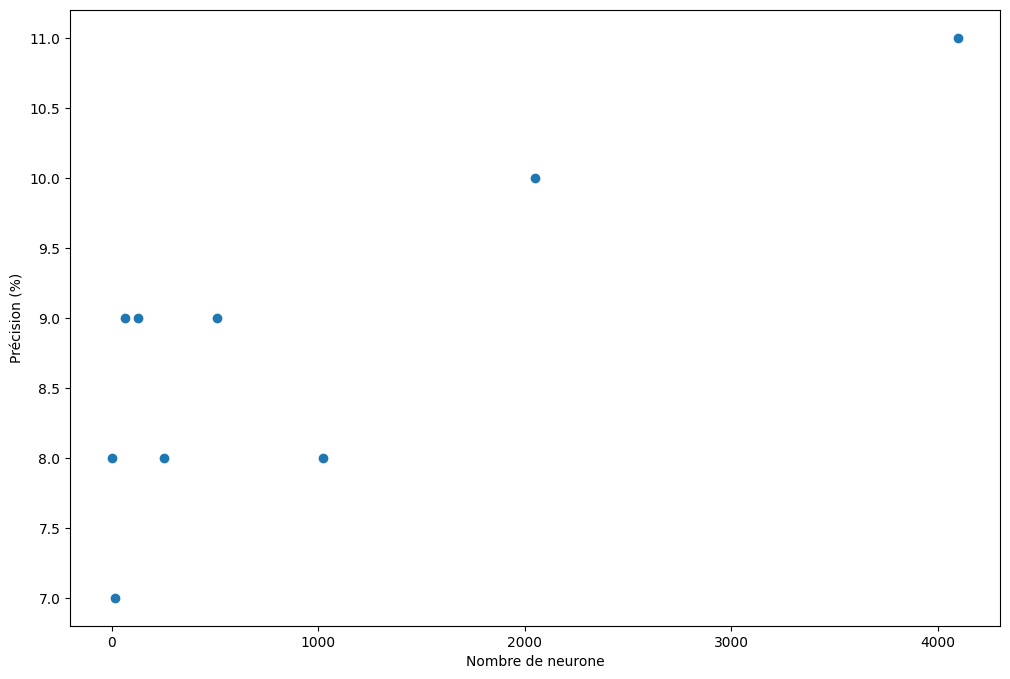

In [69]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_neurone(2,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_1 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_1))

plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel('Nombre de neurone')
plt.ylabel('Précision (%)')
plt.show()

#### Nombre d'époque

La précision maximal est obtenu pour le paramètre est 3000


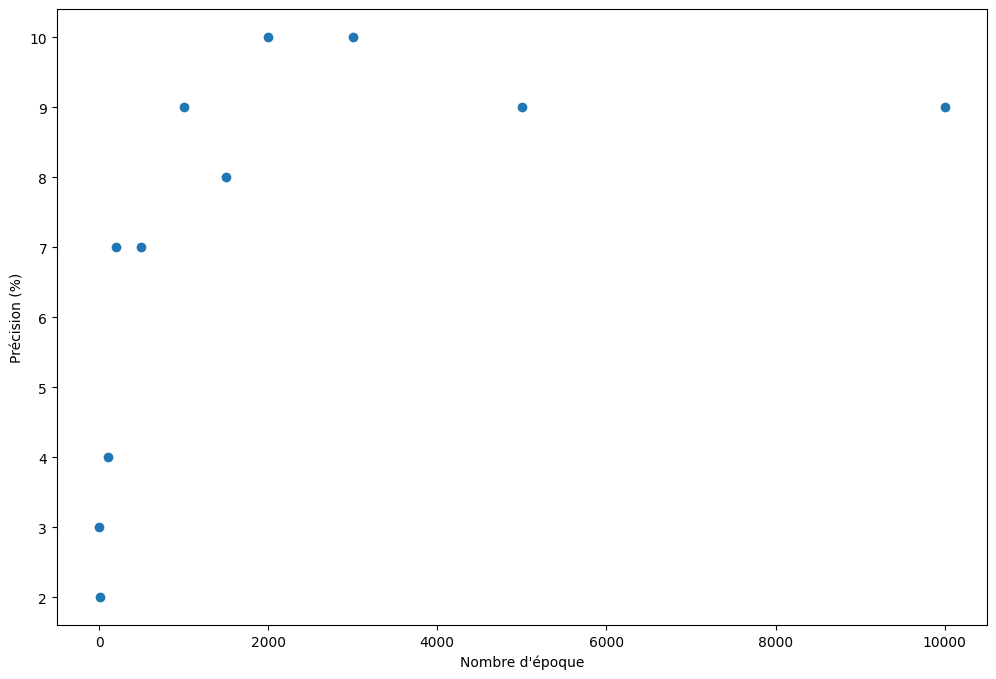

In [70]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_epoque(2,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_2 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_2))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre d'époque")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de paquet

La précision maximal est obtenu pour le paramètre  est 5


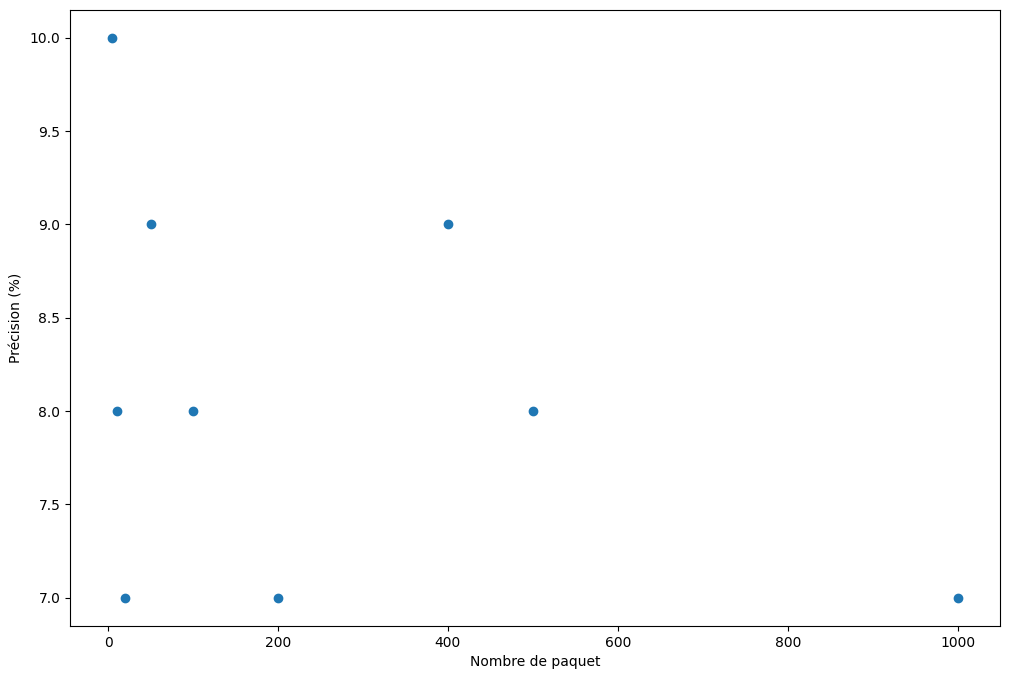

In [71]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_paquet(2,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_3 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre  est {}".format(param_3))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de paquet")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de filtre

La précision maximal est obtenu pour les paramètres est  256, 512


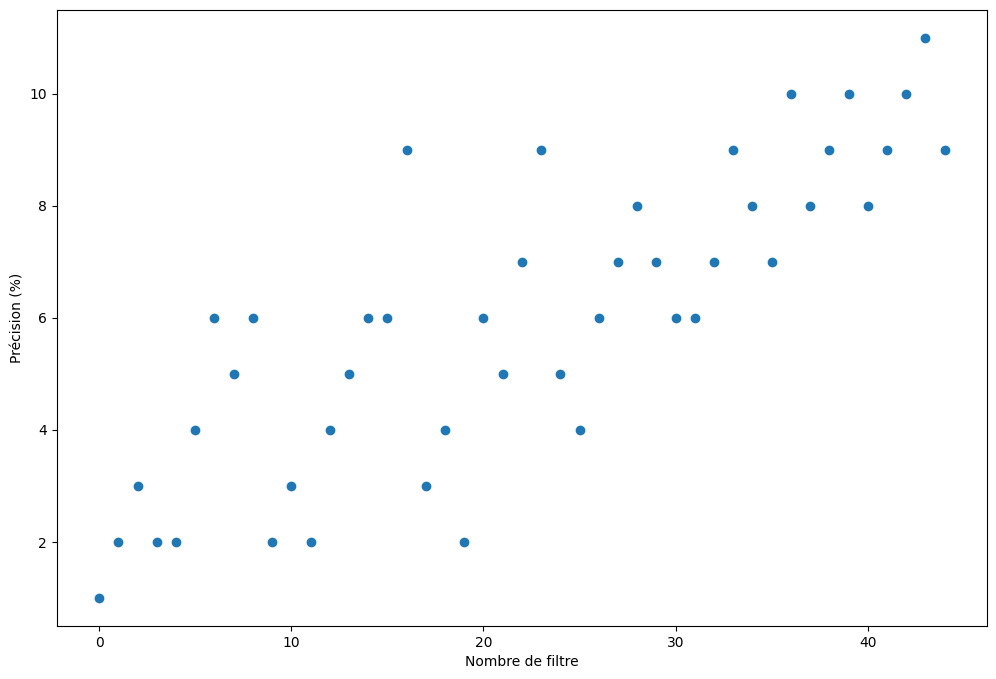

In [73]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_filtre(2,0,50000)

# On crée la liste des combinaison
filtr_comb = list(combinations_with_replacement(data,2))

index_max = accurancy_test.index(max(accurancy_test))
param_4_1 = int(filtr_comb[index_max][0])
param_4_2 = int(filtr_comb[index_max][1])
print("La précision maximal est obtenu pour les paramètres est  {}, {}".format(param_4_1,param_4_2))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de filtre")
plt.ylabel('Précision (%)')
plt.show()


#### Nombre de noyau

La précision maximal est obtenu pour les paramètres est 5, 5


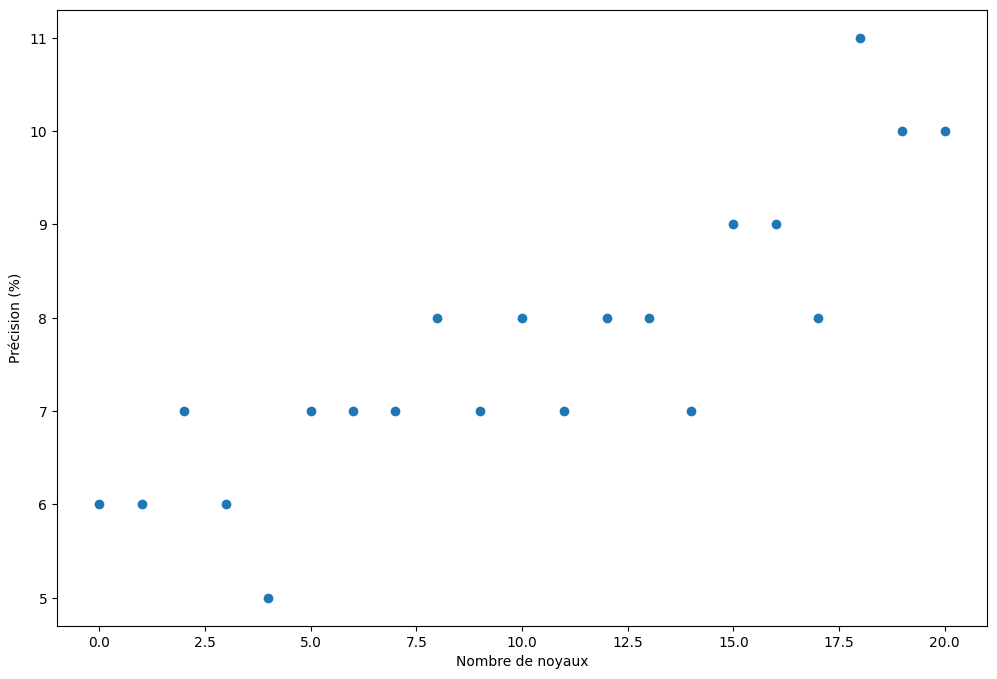

In [74]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_noyaux(2,0,50000)

# On crée la liste des combinaison
kernel_comb = list(combinations_with_replacement(data,2))

index_max = accurancy_test.index(max(accurancy_test))
param_5_1 = int(kernel_comb[index_max][0])
param_5_2 = int(kernel_comb[index_max][1])
print("La précision maximal est obtenu pour les paramètres est {}, {}".format(param_5_1,param_5_2))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de noyaux")
plt.ylabel('Précision (%)')
plt.show()


#### Pool size


La précision maximal est obtenu pour le paramètre 5


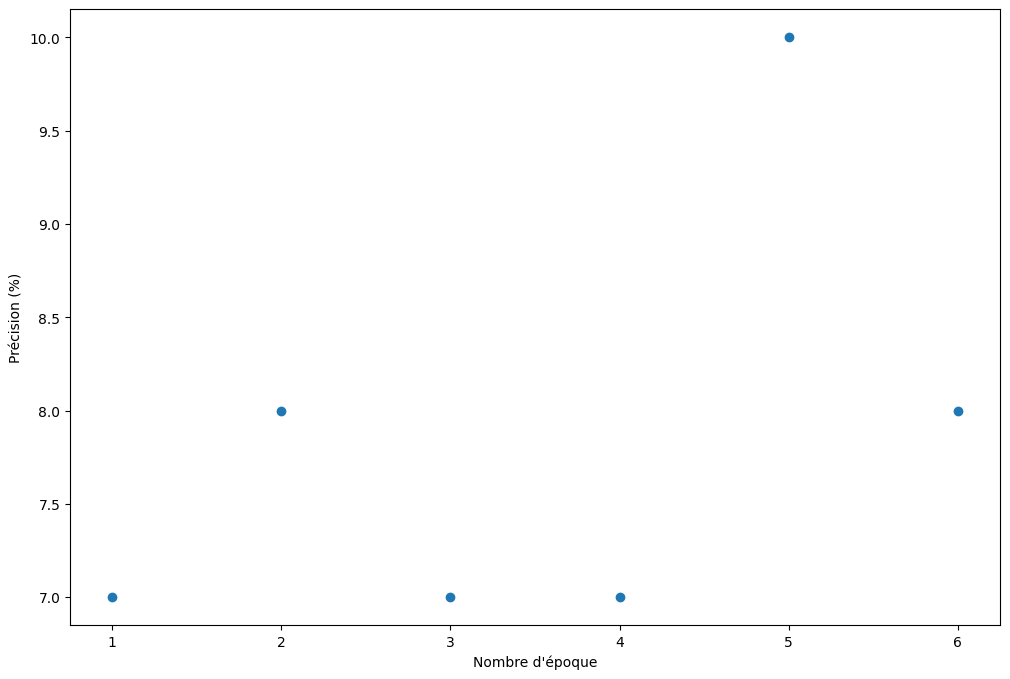

In [66]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_pool(2,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_6 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_6))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre d'époque")
plt.ylabel('Précision (%)')
plt.show()

#### Meilleurs modèle



In [85]:
# On entre les meilleurs paramètres déterminés par tests
nb_neurone = param_1
number_of_epochs = param_2
batch_size = param_3
nb_filter_1 = param_4_1
kernel_size_1 = param_5_1
pool_size_1 = param_6
nb_filter_2 = param_4_2 
kernel_size_2 = param_5_2

modele_2= models.mod_2(nb_coord,nb_class,nb_filter_1 = nb_filter_1, kernel_size_1 = kernel_size_1, pool_size_1 = pool_size_1,nb_filter_2 = nb_filter_2, kernel_size_2 = kernel_size_2,fct_activation = 'relu',nb_neurone = nb_neurone)
modele_2.compile(loss='categorical_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
history = modele_2.fit(x_train,
                    y_train_hot,
                    batch_size=param_3,
                    epochs=param_2,
                    validation_split=0.2,
                    verbose=1)

history_test = modele_2.evaluate(x_test,y_test_hot)
print("la précision du modèle avec les données de test est {}".format(history_test[1]))

Epoch 1/2000
19/19 [==============================] - 17s 883ms/step - loss: 3.7025 - accuracy: 0.0443 - val_loss: 3.5764 - val_accuracy: 0.0482
Epoch 2/2000
19/19 [==============================] - 14s 745ms/step - loss: 3.5524 - accuracy: 0.0381 - val_loss: 3.5768 - val_accuracy: 0.0570
Epoch 3/2000
19/19 [==============================] - 14s 734ms/step - loss: 3.5002 - accuracy: 0.0373 - val_loss: 3.5732 - val_accuracy: 0.0439
Epoch 4/2000
19/19 [==============================] - 14s 720ms/step - loss: 3.4972 - accuracy: 0.0522 - val_loss: 3.5839 - val_accuracy: 0.0570
Epoch 5/2000
19/19 [==============================] - 14s 727ms/step - loss: 3.5122 - accuracy: 0.0517 - val_loss: 3.5750 - val_accuracy: 0.0570
Epoch 6/2000
19/19 [==============================] - 14s 722ms/step - loss: 3.4999 - accuracy: 0.0523 - val_loss: 3.5825 - val_accuracy: 0.0439
Epoch 7/2000
19/19 [==============================] - 14s 730ms/step - loss: 3.5190 - accuracy: 0.0459 - val_loss: 3.6093 - val_ac

### Modèle 3

#### Nombre de neurones

In [6]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_neurone(3,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_1 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_1))

plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel('Nombre de neurone')
plt.ylabel('Précision (%)')
plt.show()

ERROR:root:<bound method Log.error of <distutils.log.Log object at 0x7fbf48dc32b0>>


UnboundLocalError: local variable 'data' referenced before assignment

#### Nombre d'époque

In [3]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_epoque(3,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_2 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_2))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre d'époque")
plt.ylabel('Précision (%)')
plt.show()

NameError: name 'read_test' is not defined

#### Nombre de paquet

La précision maximal est obtenu pour le paramètre  est 50


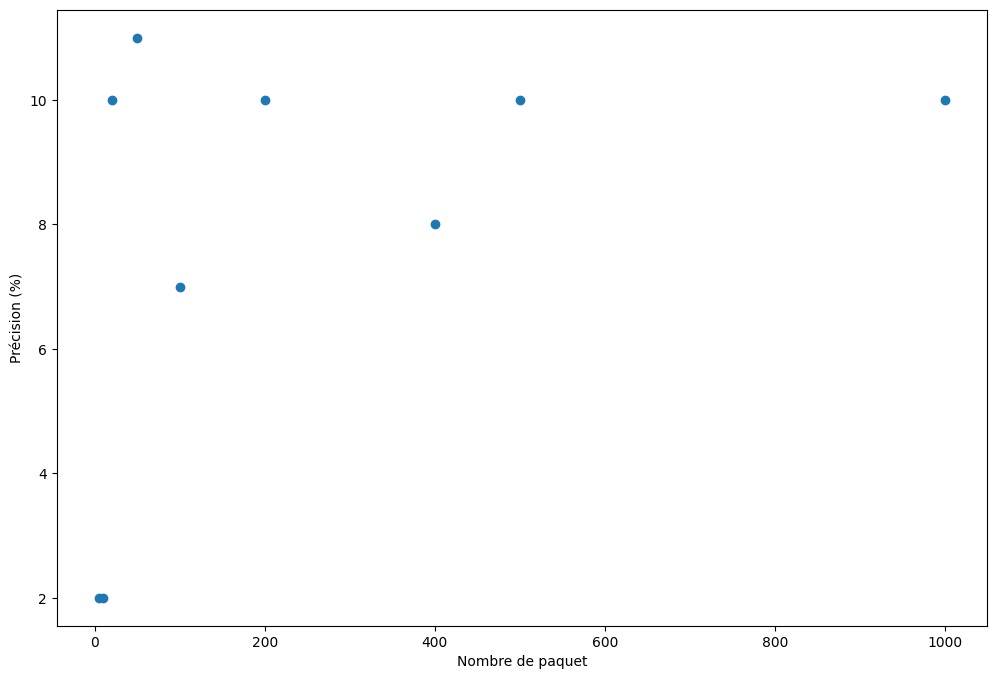

In [91]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_paquet(3,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_3 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre  est {}".format(param_3))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de paquet")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de filtre

La précision maximal est obtenu pour les paramètres est  512, 1024, 1024


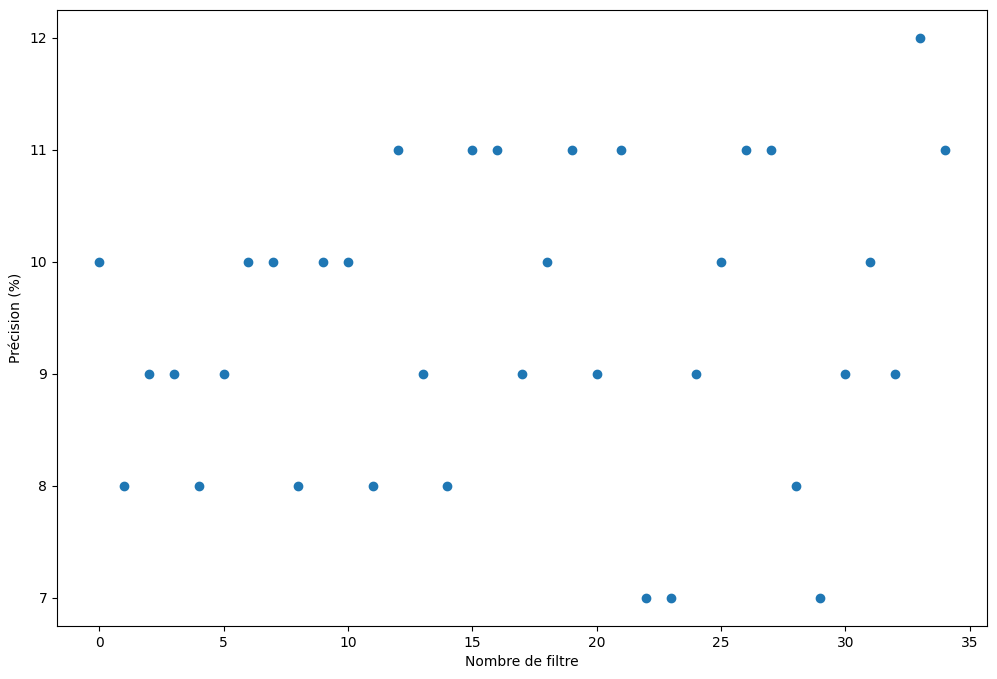

In [90]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_filtre(3,0,50000)

# On crée la liste des combinaison
filtr_comb = list(combinations_with_replacement(data,3))

index_max = accurancy_test.index(max(accurancy_test))
param_4_1 = int(filtr_comb[index_max][0])
param_4_2 = int(filtr_comb[index_max][1])
param_4_3 = int(filtr_comb[index_max][2])
print("La précision maximal est obtenu pour les paramètres est  {}, {}, {}".format(param_4_1,param_4_2,param_4_3))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de filtre")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de noyau

La précision maximal est obtenu pour les paramètres est 1, 3, 3


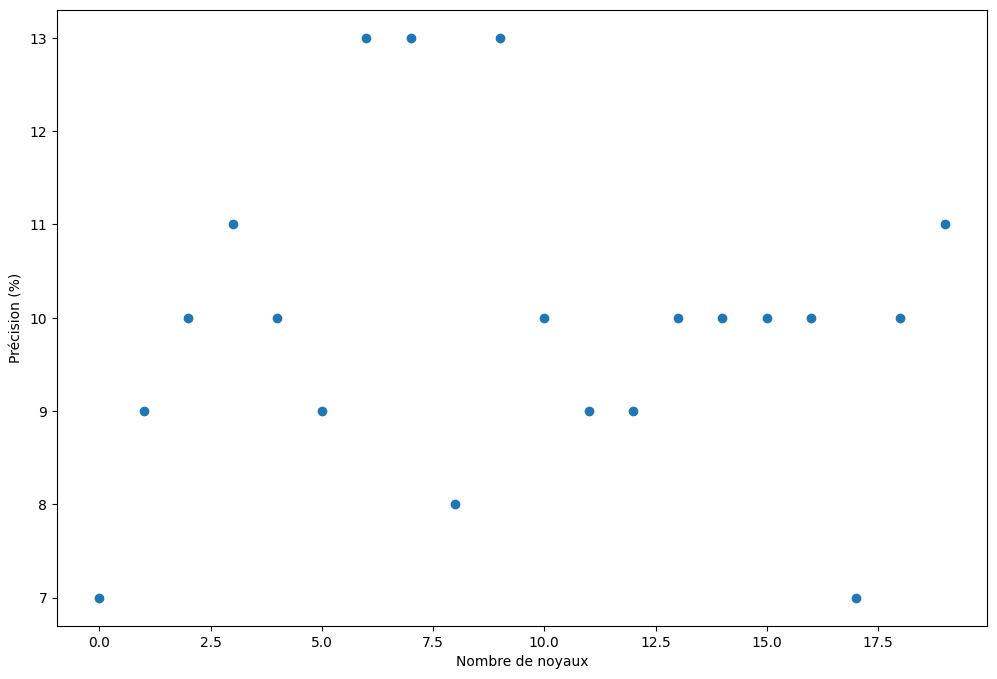

In [89]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_noyaux(3,0,50000)

# On crée la liste des combinaison
kernel_comb = list(combinations_with_replacement(data,3))

index_max = accurancy_test.index(max(accurancy_test))
param_5_1 = int(kernel_comb[index_max][0])
param_5_2 = int(kernel_comb[index_max][1])
param_5_3 = int(kernel_comb[index_max][2])
print("La précision maximal est obtenu pour les paramètres est {}, {}, {}".format(param_5_1,param_5_2,param_5_3))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de noyaux")
plt.ylabel('Précision (%)')
plt.show()

#### Coefficient Drop


La précision maximal est obtenu pour les paramètres est 1, 1, 3, 3


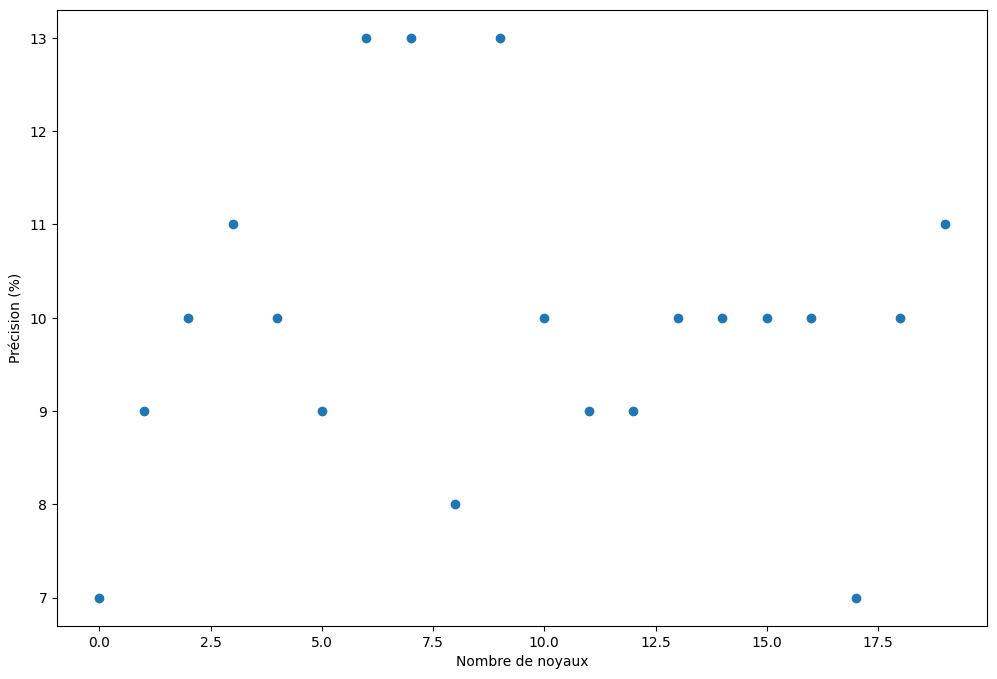

In [88]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_noyaux(3,0,50000)

# On crée la liste des combinaison
drop_comb = list(combinations_with_replacement(data,4))

index_max = accurancy_test.index(max(accurancy_test))
param_6_1 = int(drop_comb[index_max][0])
param_6_2 = int(drop_comb[index_max][1])
param_6_3 = int(drop_comb[index_max][2])
param_6_4 = int(drop_comb[index_max][3])
print("La précision maximal est obtenu pour les paramètres est {}, {}, {}, {}".format(param_6_1,param_6_2,param_6_3,param_6_4))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de noyaux")
plt.ylabel('Précision (%)')
plt.show()

#### Meilleur modèle

In [1]:
# On entre les meilleurs paramètres déterminés par tests
nb_neurone = param_1
number_of_epochs = param_2
batch_size = param_3
nb_filter_1 = param_4_1
kernel_size_1 = param_5_1
pool_size_1 =3
drop1 = param_6_1
nb_filter_2 = param_4_2
kernel_size_2 = param_5_1
pool_size_2 = 3
drop2 = param_6_2
nb_filter_3 = param_4_3
kernel_size_3 = param_5_1
drop3 = param_6_3
drop4 = param_6_4

print(param_2,batch_size,nb_filter_1, kernel_size_1, pool_size_1,drop1,  nb_filter_2,  kernel_size_2, pool_size_2,drop2, nb_filter_3,  kernel_size_3, drop3, drop4,nb_neurone)
modele= models.mod_3(nb_coord,nb_class,nb_filter_1 = nb_filter_1, kernel_size_1 =kernel_size_1, pool_size_1 = pool_size_1,drop1  =drop1, nb_filter_2 = nb_filter_2, kernel_size_2 = kernel_size_2, pool_size_2 = pool_size_2,drop2 = drop2, nb_filter_3 = nb_filter_3, kernel_size_3 = kernel_size_3, drop3 = drop3,drop4 = drop4,fct_activation = 'relu',nb_neurone = nb_neurone)
modele.compile(loss='categorical_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
history = modele.fit(x_train,
                    y_train_hot,
                    batch_size=batch_size,
                    epochs=number_of_epochs,
                    validation_split=0.2,
                    verbose=1)

history_test = modele.evaluate(x_test,y_test_hot)
print("la précision du modèle avec les données de test est {}".format(history_test[1]))

NameError: name 'param_1' is not defined

### Modèle 4

#### Nombre de neurone

In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_neurone(4,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_1 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_1))

plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel('Nombre de neurone')
plt.ylabel('Précision (%)')
plt.show()

#### Nombre d'époque

In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_epoque(4,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_2 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre est {}".format(param_2))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre d'époque")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de paquet

In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_paquet(4,0,50000)

index_max = accurancy_test.index(max(accurancy_test))
param_3 = int(data[index_max])
print("La précision maximal est obtenu pour le paramètre  est {}".format(param_3))
plt.figure(figsize = (12,8))
plt.scatter(data,np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de paquet")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de filtres

In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_filtre(3,0,50000)

# On crée la liste des combinaison
filtr_comb = list(combinations_with_replacement(data,3))

index_max = accurancy_test.index(max(accurancy_test))
param_4_1 = int(filtr_comb[index_max][0])
param_4_2 = int(filtr_comb[index_max][1])
param_4_3 = int(filtr_comb[index_max][2])
print("La précision maximal est obtenu pour les paramètres est  {}, {}, {}".format(param_4_1,param_4_2,param_4_3))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de filtre")
plt.ylabel('Précision (%)')
plt.show()

#### Nombre de noyau

In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_noyaux(3,0,50000)

# On crée la liste des combinaison
kernel_comb = list(combinations_with_replacement(data,3))

index_max = accurancy_test.index(max(accurancy_test))
param_5_1 = int(kernel_comb[index_max][0])
param_5_2 = int(kernel_comb[index_max][1])
param_5_3 = int(kernel_comb[index_max][2])
print("La précision maximal est obtenu pour les paramètres est {}, {}, {}".format(param_5_1,param_5_2,param_5_3))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de noyaux")
plt.ylabel('Précision (%)')
plt.show()

#### Coefficient Drop


In [ ]:
data,accurancy_train,loss_train, accurancy_val_train, loss_val_train,accurancy_test,loss_test = read_test.nb_noyaux(3,0,50000)

# On crée la liste des combinaison
drop_comb = list(combinations_with_replacement(data,3))

index_max = accurancy_test.index(max(accurancy_test))
param_6_1 = int(drop_comb[index_max][0])
param_6_2 = int(drop_comb[index_max][1])
param_6_3 = int(drop_comb[index_max][2])
print("La précision maximal est obtenu pour les paramètres est {}, {}, {}".format(param_6_1,param_6_2,param_6_3))
plt.figure(figsize = (12,8))
plt.scatter([i for i in range(len(accurancy_train))],np.round(np.array(accurancy_test)*100,0))
plt.xlabel("Nombre de noyaux")
plt.ylabel('Précision (%)')
plt.show()

#### Meilleur modèle

In [ ]:
# On entre les meilleurs paramètres déterminés par tests
nb_neurone = param_1
number_of_epochs = param_2
batch_size = param_3
nb_filter_1 = param_4_1
kernel_size_1 = param_5_1
pool_size_1 =3
drop1 = param_6_1
nb_filter_2 = param_4_2
kernel_size_2 = param_5_1
pool_size_2 = 3
drop2 = param_6_2
nb_filter_3 = param_4_3
kernel_size_3 = param_5_1
drop3 = param_6_3
pool_size_3 = 3

modele= models.mod_4(nb_coord,nb_class,nb_filter_1 = nb_filter_1, kernel_size_1 = kernel_size_1, pool_size_1 = pool_size_1, nb_drop1 =drop1,nb_filter_2 = nb_filter_2, kernel_size_2 = kernel_size_2, pool_size_2 = pool_size_2, nb_drop2 =drop2,nb_filter_3 = nb_filter_3, kernel_size_3 = kernel_size_3, pool_size_3 = pool_size_3, nb_drop3 =drop3,fct_activation = 'relu',nb_neurone = nb_neurone)
modele.compile(loss='categorical_crossentropy',
                            optimizer='adam', metrics=['accuracy'])
history = modele.fit([x_train,x_train,x_train],
                    y_train_hot,
                    batch_size=batch_size,
                    epochs=number_of_epochs,
                    validation_split=0.2,
                    verbose=0)

history_test = modele.evaluate([x_test,x_test,x_test],y_test_hot)
print("la précision du modèle avec les données de test est {}".format(history_test[1]))